In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from datetime import datetime
import os

print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


In [ ]:
# Загрузка и подготовка данных
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Размеры данных:")
print(f"Обучающая выборка: {x_train.shape}")
print(f"Валидационная выборка: {x_val.shape}")
print(f"Тестовая выборка: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Размеры данных:
Обучающая выборка: (40000, 32, 32, 3)
Валидационная выборка: (10000, 32, 32, 3)
Тестовая выборка: (10000, 32, 32, 3)


In [ ]:
# Реализация слоя Dropout
class CustomDropout(layers.Layer):
    def __init__(self, rate, **kwargs):
        super(CustomDropout, self).__init__(**kwargs)
        self.rate = rate
        self.seed_generator = tf.random.Generator.from_seed(42)

    def call(self, inputs, training=None):
        if training:
            random_tensor = self.seed_generator.uniform(
                shape=tf.shape(inputs),
                minval=0,
                maxval=1
            )
            keep_mask = random_tensor >= self.rate
            scale = 1.0 / (1.0 - self.rate)
            outputs = tf.where(keep_mask, inputs * scale, 0.0)
            return outputs
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({"rate": self.rate})
        return config

print("Кастомный слой Dropout реализован")

Кастомный слой Dropout реализован


In [ ]:
# Создание модели CNN с Dropout
def create_cnn_model(with_dropout=True, dropout_rate=0.3):
    model = keras.Sequential()

    # Первый сверточный блок
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                           input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    if with_dropout:
        model.add(CustomDropout(dropout_rate))
    model.add(layers.MaxPooling2D((2, 2)))

    # Второй сверточный блок
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    if with_dropout:
        model.add(CustomDropout(dropout_rate))
    model.add(layers.MaxPooling2D((2, 2)))

    # Третий сверточный блок
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    if with_dropout:
        model.add(CustomDropout(dropout_rate))
    model.add(layers.MaxPooling2D((2, 2)))

    # Полносвязные слои
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    if with_dropout:
        model.add(CustomDropout(dropout_rate))
    model.add(layers.Dense(64, activation='relu'))
    if with_dropout:
        model.add(CustomDropout(dropout_rate))
    model.add(layers.Dense(10, activation='softmax'))

    return model

print("Функция создания модели определена")

Функция создания модели определена


In [ ]:
#Создание моделей для сравнения
model_with_dropout = create_cnn_model(with_dropout=True, dropout_rate=0.3)
model_without_dropout = create_cnn_model(with_dropout=False)

model_with_dropout.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_without_dropout.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Модели созданы и скомпилированы")
print(f"Модель с Dropout: {model_with_dropout.count_params()} параметров")
print(f"Модель без Dropout: {model_without_dropout.count_params()} параметров")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Модели созданы и скомпилированы
Модель с Dropout: 365322 параметров
Модель без Dropout: 365322 параметров


In [ ]:
#Callback для сохранения моделей на разных эпохах
class ModelCheckpointAtEpochs(keras.callbacks.Callback):
    def __init__(self, epochs_to_save, model_name):
        super().__init__()
        self.epochs_to_save = epochs_to_save
        self.model_name = model_name
        self.saved_models = {}

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) in self.epochs_to_save:
            model_path = f"{self.model_name}_epoch_{epoch+1}.h5"
            self.model.save(model_path)
            self.saved_models[epoch+1] = model_path
            print(f"Модель сохранена: {model_path}")
os.makedirs('saved_models', exist_ok=True)
os.chdir('saved_models')

epochs_to_save = [5, 10, 15, 20]

In [ ]:
# Обучение
print("Начало обучения модели с Dropout...")
checkpoint_dropout = ModelCheckpointAtEpochs(epochs_to_save, "model_with_dropout")

history_dropout = model_with_dropout.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_dropout],
    verbose=1
)

print("\nНачало обучения модели без Dropout...")
checkpoint_no_dropout = ModelCheckpointAtEpochs(epochs_to_save, "model_without_dropout")

history_no_dropout = model_without_dropout.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_no_dropout],
    verbose=1
)

print("Обучение завершено!")

Начало обучения модели с Dropout...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 255ms/step - accuracy: 0.2639 - loss: 2.0911 - val_accuracy: 0.2740 - val_loss: 2.5738
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.4513 - loss: 1.5077 - val_accuracy: 0.3890 - val_loss: 2.2094
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.5493 - loss: 1.2798 - val_accuracy: 0.5667 - val_loss: 1.3762
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.5992 - loss: 1.1499 - val_accuracy: 0.5566 - val_loss: 1.4853
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6392 - loss: 1.0632

Модель сохранена: model_with_dropout_epoch_5.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.6392 - loss: 1.0631 - val_accuracy: 0.5241 - val_loss: 1.9586
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.6685 - loss: 0.9745 - val_accuracy: 0.4941 - val_loss: 1.9435
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 235ms/step - accuracy: 0.6867 - loss: 0.9285 - val_accuracy: 0.5418 - val_loss: 1.7974
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7022 - loss: 0.8781 - val_accuracy: 0.6154 - val_loss: 1.3205
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 236ms/step - accuracy: 0.7180 - loss: 0.8424 - val_accuracy: 0.6376 - val_loss: 1.2331
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7299 - loss: 0.8038

Модель сохранена: model_with_dropout_epoch_10.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 199s 231ms/step - accuracy: 0.7299 - loss: 0.8038 - val_accuracy: 0.6529 - val_loss: 1.1667
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 232ms/step - accuracy: 0.7354 - loss: 0.7791 - val_accuracy: 0.6268 - val_loss: 1.4002
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 230ms/step - accuracy: 0.7491 - loss: 0.7483 - val_accuracy: 0.6612 - val_loss: 1.1601
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 204s 232ms/step - accuracy: 0.7525 - loss: 0.7282 - val_accuracy: 0.6172 - val_loss: 1.5175
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.7594 - loss: 0.7115 - val_accuracy: 0.6031 - val_loss: 1.5724
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7721 - loss: 0.6815

Модель сохранена: model_with_dropout_epoch_15.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.7721 - loss: 0.6815 - val_accuracy: 0.6146 - val_loss: 1.2750
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 239ms/step - accuracy: 0.7803 - loss: 0.6459 - val_accuracy: 0.7286 - val_loss: 0.8649
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.7828 - loss: 0.6462 - val_accuracy: 0.6968 - val_loss: 1.0076
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.7930 - loss: 0.6204 - val_accuracy: 0.6016 - val_loss: 1.6372
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 231ms/step - accuracy: 0.7987 - loss: 0.6028 - val_accuracy: 0.7318 - val_loss: 0.9135
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7953 - loss: 0.6027

Модель сохранена: model_with_dropout_epoch_20.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 237ms/step - accuracy: 0.7953 - loss: 0.6027 - val_accuracy: 0.7044 - val_loss: 1.0472

Начало обучения модели без Dropout...
Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 128s 200ms/step - accuracy: 0.4463 - loss: 1.5772 - val_accuracy: 0.5598 - val_loss: 1.2404
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 198ms/step - accuracy: 0.6790 - loss: 0.9209 - val_accuracy: 0.5909 - val_loss: 1.2097
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 196ms/step - accuracy: 0.7469 - loss: 0.7219 - val_accuracy: 0.6813 - val_loss: 0.9451
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.8002 - loss: 0.5709 - val_accuracy: 0.6946 - val_loss: 0.9272
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8351 - loss: 0.4687

Модель сохранена: model_without_dropout_epoch_5.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 204ms/step - accuracy: 0.8351 - loss: 0.4687 - val_accuracy: 0.6919 - val_loss: 0.9589
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 203ms/step - accuracy: 0.8796 - loss: 0.3510 - val_accuracy: 0.6461 - val_loss: 1.2810
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 199ms/step - accuracy: 0.9033 - loss: 0.2774 - val_accuracy: 0.7289 - val_loss: 0.9677
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 209ms/step - accuracy: 0.9278 - loss: 0.2129 - val_accuracy: 0.6939 - val_loss: 1.2528
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.9390 - loss: 0.1765 - val_accuracy: 0.7167 - val_loss: 1.2277
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9521 - loss: 0.1375

Модель сохранена: model_without_dropout_epoch_10.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 204ms/step - accuracy: 0.9521 - loss: 0.1375 - val_accuracy: 0.7160 - val_loss: 1.2886
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.9607 - loss: 0.1178 - val_accuracy: 0.7252 - val_loss: 1.3137
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 0.9628 - loss: 0.1061 - val_accuracy: 0.6901 - val_loss: 1.5427
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 122s 196ms/step - accuracy: 0.9676 - loss: 0.0934 - val_accuracy: 0.6891 - val_loss: 1.9349
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 202ms/step - accuracy: 0.9660 - loss: 0.0992 - val_accuracy: 0.7259 - val_loss: 1.5254
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9729 - loss: 0.0788

Модель сохранена: model_without_dropout_epoch_15.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 123s 198ms/step - accuracy: 0.9729 - loss: 0.0789 - val_accuracy: 0.7299 - val_loss: 1.5929
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - accuracy: 0.9723 - loss: 0.0782 - val_accuracy: 0.7094 - val_loss: 1.5989
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 127s 203ms/step - accuracy: 0.9742 - loss: 0.0744 - val_accuracy: 0.7185 - val_loss: 1.6271
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 199ms/step - accuracy: 0.9769 - loss: 0.0668 - val_accuracy: 0.7141 - val_loss: 1.6443
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 200ms/step - accuracy: 0.9767 - loss: 0.0675 - val_accuracy: 0.6924 - val_loss: 1.7769
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9768 - loss: 0.0656

Модель сохранена: model_without_dropout_epoch_20.h5
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 204ms/step - accuracy: 0.9768 - loss: 0.0656 - val_accuracy: 0.7177 - val_loss: 1.7373
Обучение завершено!


In [ ]:
#визуализация
def plot_training_history(history_dropout, history_no_dropout):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Точность обучения
    axes[0, 0].plot(history_dropout.history['accuracy'], label='С Dropout', linewidth=2)
    axes[0, 0].plot(history_no_dropout.history['accuracy'], label='Без Dropout', linewidth=2)
    axes[0, 0].set_title('Точность на обучающей выборке')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Точность')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Потери обучения
    axes[0, 1].plot(history_dropout.history['loss'], label='С Dropout', linewidth=2)
    axes[0, 1].plot(history_no_dropout.history['loss'], label='Без Dropout', linewidth=2)
    axes[0, 1].set_title('Потери на обучающей выборке')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('Потери')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Точность валидации
    axes[1, 0].plot(history_dropout.history['val_accuracy'], label='С Dropout', linewidth=2)
    axes[1, 0].plot(history_no_dropout.history['val_accuracy'], label='Без Dropout', linewidth=2)
    axes[1, 0].set_title('Точность на валидационной выборке')
    axes[1, 0].set_xlabel('Эпоха')
    axes[1, 0].set_ylabel('Точность')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Потери валидации
    axes[1, 1].plot(history_dropout.history['val_loss'], label='С Dropout', linewidth=2)
    axes[1, 1].plot(history_no_dropout.history['val_loss'], label='Без Dropout', linewidth=2)
    axes[1, 1].set_title('Потери на валидационной выборке')
    axes[1, 1].set_xlabel('Эпоха')
    axes[1, 1].set_ylabel('Потери')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_comparison_at_epochs(histories, epochs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    val_acc_dropout = [histories['dropout'].history['val_accuracy'][epoch-1] for epoch in epochs]
    val_acc_no_dropout = [histories['no_dropout'].history['val_accuracy'][epoch-1] for epoch in epochs]

    # Сравнение точности
    axes[0].bar(np.array(epochs) - 0.2, val_acc_dropout, width=0.4, label='С Dropout', alpha=0.8)
    axes[0].bar(np.array(epochs) + 0.2, val_acc_no_dropout, width=0.4, label='Без Dropout', alpha=0.8)
    axes[0].set_title('Сравнение точности на разных эпохах')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность валидации')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Сравнение потерь
    val_loss_dropout = [histories['dropout'].history['val_loss'][epoch-1] for epoch in epochs]
    val_loss_no_dropout = [histories['no_dropout'].history['val_loss'][epoch-1] for epoch in epochs]

    axes[1].bar(np.array(epochs) - 0.2, val_loss_dropout, width=0.4, label='С Dropout', alpha=0.8)
    axes[1].bar(np.array(epochs) + 0.2, val_loss_no_dropout, width=0.4, label='Без Dropout', alpha=0.8)
    axes[1].set_title('Сравнение потерь на разных эпохах')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Потери валидации')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Функции визуализации созданы")

Функции визуализации созданы


Визуализация процесса обучения...


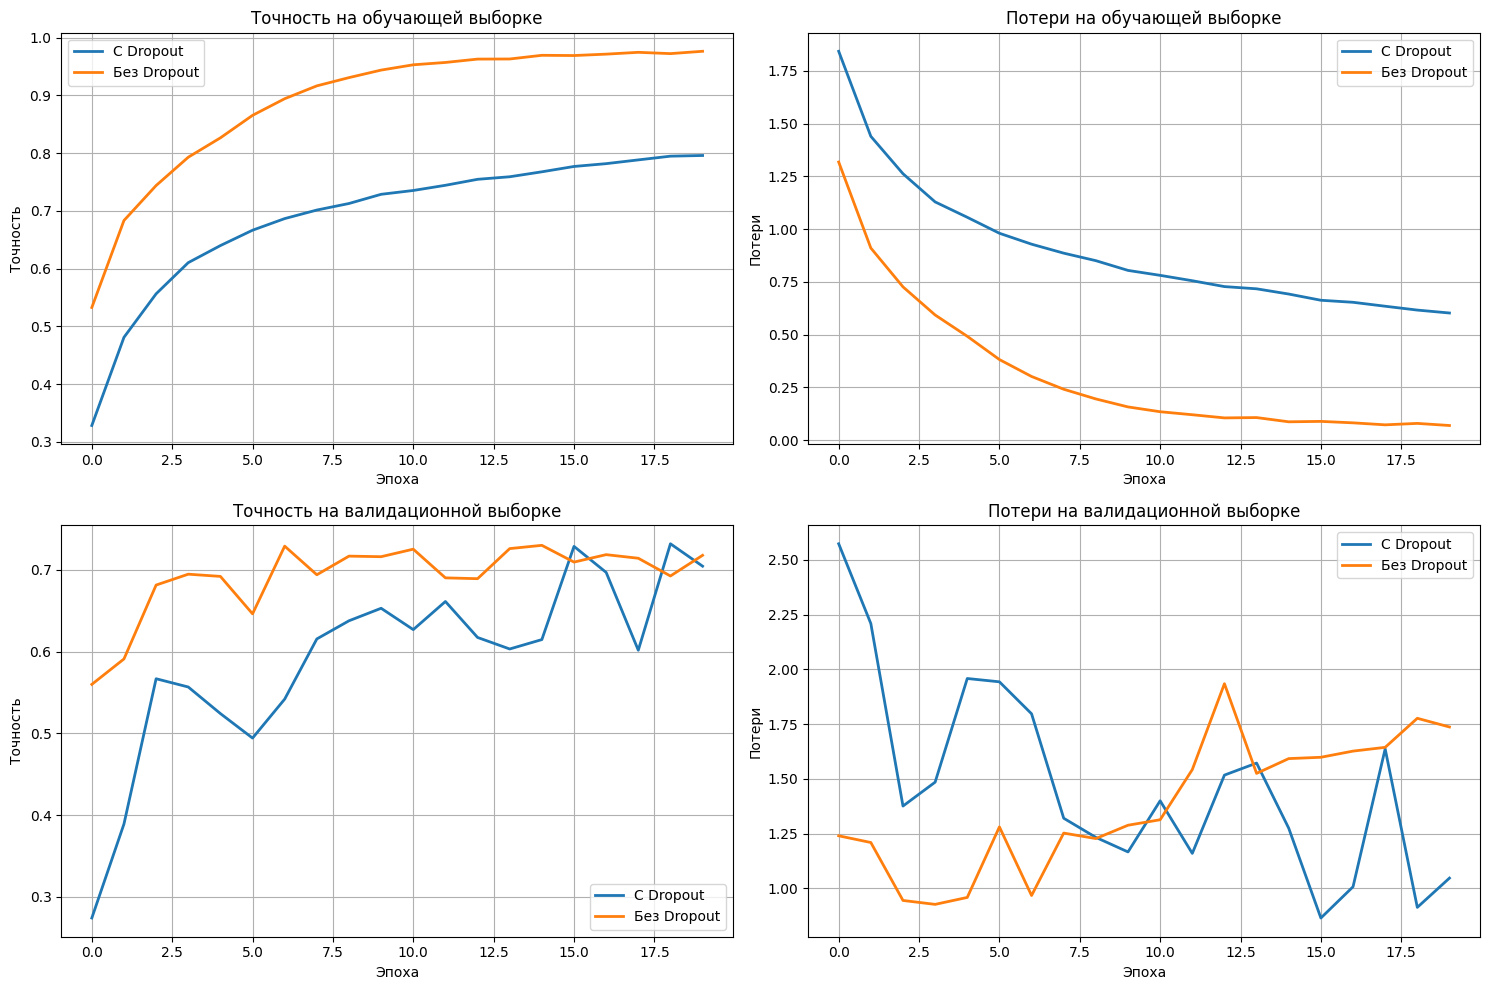

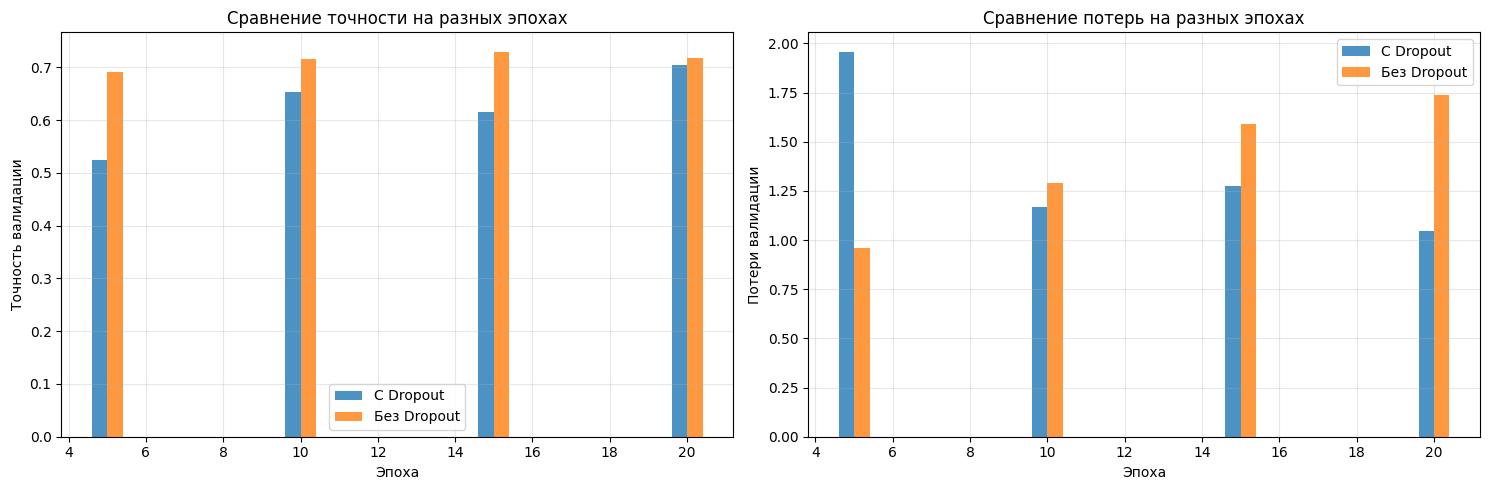

In [ ]:
print("Визуализация процесса обучения...")
plot_training_history(history_dropout, history_no_dropout)

histories = {
    'dropout': history_dropout,
    'no_dropout': history_no_dropout
}
plot_comparison_at_epochs(histories, epochs_to_save)

Тестирование моделей на тестовой выборке...
Результаты тестирования:
Модель с Dropout - Точность: 0.6939, Потери: 1.0707
Модель без Dropout - Точность: 0.7218, Потери: 1.7275


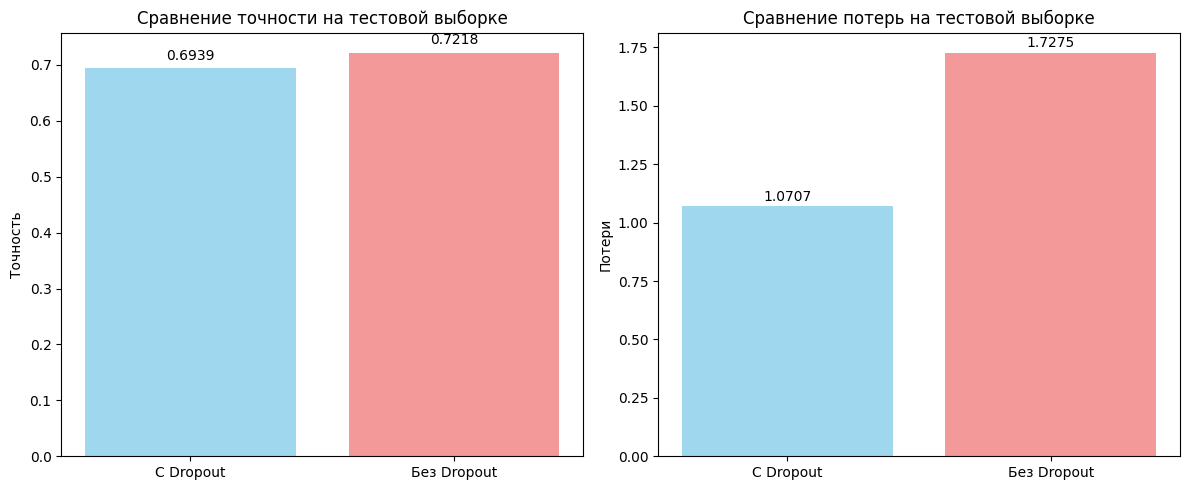

In [ ]:
print("Тестирование моделей на тестовой выборке...")

# Тестирование модели с Dropout
test_loss_dropout, test_acc_dropout = model_with_dropout.evaluate(x_test, y_test, verbose=0)

# Тестирование модели без Dropout
test_loss_no_dropout, test_acc_no_dropout = model_without_dropout.evaluate(x_test, y_test, verbose=0)

print("Результаты тестирования:")
print(f"Модель с Dropout - Точность: {test_acc_dropout:.4f}, Потери: {test_loss_dropout:.4f}")
print(f"Модель без Dropout - Точность: {test_acc_no_dropout:.4f}, Потери: {test_loss_no_dropout:.4f}")

# Визуализация сравнения тестовых результатов
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Сравнение точности
models = ['С Dropout', 'Без Dropout']
test_accuracies = [test_acc_dropout, test_acc_no_dropout]
test_losses = [test_loss_dropout, test_loss_no_dropout]

axes[0].bar(models, test_accuracies, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0].set_title('Сравнение точности на тестовой выборке')
axes[0].set_ylabel('Точность')
for i, v in enumerate(test_accuracies):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

axes[1].bar(models, test_losses, color=['skyblue', 'lightcoral'], alpha=0.8)
axes[1].set_title('Сравнение потерь на тестовой выборке')
axes[1].set_ylabel('Потери')
for i, v in enumerate(test_losses):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Анализ переобучения...


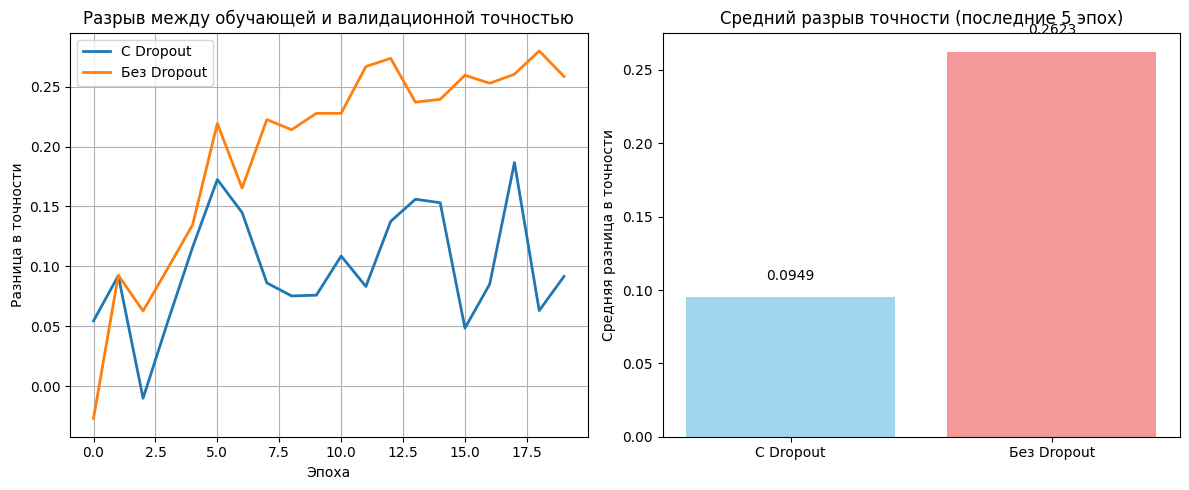

Средний разрыв с Dropout: 0.0949
Средний разрыв без Dropout: 0.2623
Dropout уменьшил переобучение на: 63.81%


In [ ]:
def analyze_overfitting(history_dropout, history_no_dropout):
    # Разница между обучающей и валидационной точностью (показатель переобучения)
    overfitting_gap_dropout = [train_acc - val_acc for train_acc, val_acc in
                              zip(history_dropout.history['accuracy'],
                                  history_dropout.history['val_accuracy'])]

    overfitting_gap_no_dropout = [train_acc - val_acc for train_acc, val_acc in
                                 zip(history_no_dropout.history['accuracy'],
                                     history_no_dropout.history['val_accuracy'])]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(overfitting_gap_dropout, label='С Dropout', linewidth=2)
    plt.plot(overfitting_gap_no_dropout, label='Без Dropout', linewidth=2)
    plt.title('Разрыв между обучающей и валидационной точностью')
    plt.xlabel('Эпоха')
    plt.ylabel('Разница в точности')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # Средний разрыв за последние 5 эпох
    avg_gap_dropout = np.mean(overfitting_gap_dropout[-5:])
    avg_gap_no_dropout = np.mean(overfitting_gap_no_dropout[-5:])

    plt.bar(['С Dropout', 'Без Dropout'], [avg_gap_dropout, avg_gap_no_dropout],
            color=['skyblue', 'lightcoral'], alpha=0.8)
    plt.title('Средний разрыв точности (последние 5 эпох)')
    plt.ylabel('Средняя разница в точности')

    for i, v in enumerate([avg_gap_dropout, avg_gap_no_dropout]):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"Средний разрыв с Dropout: {avg_gap_dropout:.4f}")
    print(f"Средний разрыв без Dropout: {avg_gap_no_dropout:.4f}")
    print(f"Dropout уменьшил переобучение на: {(avg_gap_no_dropout - avg_gap_dropout)/avg_gap_no_dropout*100:.2f}%")

print("Анализ переобучения...")
analyze_overfitting(history_dropout, history_no_dropout)

In [ ]:
def demonstrate_dropout_effect():
    # Создаем тестовый тензор
    test_input = tf.constant([[1.0, 2.0, 3.0, 4.0, 5.0]], dtype=tf.float32)
    dropout_layer = CustomDropout(rate=0.5)

    print("Демонстрация работы Dropout:")
    print(f"Исходный тензор: {test_input.numpy()}")

    # В режиме обучения
    training_output = dropout_layer(test_input, training=True)
    print(f"Выход при обучении: {training_output.numpy()}")

    # В режиме инференса
    inference_output = dropout_layer(test_input, training=False)
    print(f"Выход при инференсе: {inference_output.numpy()}")

demonstrate_dropout_effect()

Демонстрация работы Dropout:
Исходный тензор: [[1. 2. 3. 4. 5.]]
Выход при обучении: [[2. 4. 0. 0. 0.]]
Выход при инференсе: [[1. 2. 3. 4. 5.]]


In [ ]:
def save_final_results(history_dropout, history_no_dropout, test_results):
    results = {
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'final_epochs': {
            'with_dropout': {
                'train_accuracy': history_dropout.history['accuracy'][-1],
                'train_loss': history_dropout.history['loss'][-1],
                'val_accuracy': history_dropout.history['val_accuracy'][-1],
                'val_loss': history_dropout.history['val_loss'][-1],
                'test_accuracy': test_results['with_dropout']['accuracy'],
                'test_loss': test_results['with_dropout']['loss']
            },
            'without_dropout': {
                'train_accuracy': history_no_dropout.history['accuracy'][-1],
                'train_loss': history_no_dropout.history['loss'][-1],
                'val_accuracy': history_no_dropout.history['val_accuracy'][-1],
                'val_loss': history_no_dropout.history['val_loss'][-1],
                'test_accuracy': test_results['without_dropout']['accuracy'],
                'test_loss': test_results['without_dropout']['loss']
            }
        }
    }

    # Сохраняем результаты в файл
    with open('training_results.txt', 'w') as f:
        f.write("РЕЗУЛЬТАТЫ ЭКСПЕРИМЕНТА С DROPOUT\n")
        f.write("=" * 50 + "\n")
        f.write(f"Дата проведения: {results['timestamp']}\n\n")

        f.write("МОДЕЛЬ С DROPOUT:\n")
        f.write(f"  Обучающая точность: {results['final_epochs']['with_dropout']['train_accuracy']:.4f}\n")
        f.write(f"  Валидационная точность: {results['final_epochs']['with_dropout']['val_accuracy']:.4f}\n")
        f.write(f"  Тестовая точность: {results['final_epochs']['with_dropout']['test_accuracy']:.4f}\n")
        f.write(f"  Обучающие потери: {results['final_epochs']['with_dropout']['train_loss']:.4f}\n")
        f.write(f"  Валидационные потери: {results['final_epochs']['with_dropout']['val_loss']:.4f}\n")
        f.write(f"  Тестовые потери: {results['final_epochs']['with_dropout']['test_loss']:.4f}\n\n")

        f.write("МОДЕЛЬ БЕЗ DROPOUT:\n")
        f.write(f"  Обучающая точность: {results['final_epochs']['without_dropout']['train_accuracy']:.4f}\n")
        f.write(f"  Валидационная точность: {results['final_epochs']['without_dropout']['val_accuracy']:.4f}\n")
        f.write(f"  Тестовая точность: {results['final_epochs']['without_dropout']['test_accuracy']:.4f}\n")
        f.write(f"  Обучающие потери: {results['final_epochs']['without_dropout']['train_loss']:.4f}\n")
        f.write(f"  Валидационные потери: {results['final_epochs']['without_dropout']['val_loss']:.4f}\n")
        f.write(f"  Тестовые потери: {results['final_epochs']['without_dropout']['test_loss']:.4f}\n\n")

        improvement = (results['final_epochs']['with_dropout']['test_accuracy'] -
                      results['final_epochs']['without_dropout']['test_accuracy'])
        f.write(f"УЛУЧШЕНИЕ ОТ DROPOUT: {improvement:.4f}\n")

    print("Результаты сохранены в файл 'training_results.txt'")

test_results = {
    'with_dropout': {'accuracy': test_acc_dropout, 'loss': test_loss_dropout},
    'without_dropout': {'accuracy': test_acc_no_dropout, 'loss': test_loss_no_dropout}
}

save_final_results(history_dropout, history_no_dropout, test_results)

Результаты сохранены в файл 'training_results.txt'
